# Deep learning
## Melanoma skin cancer detection

#### Problem Statement:
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [38]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from glob import glob

import Augmentor

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("CNN_assignment\Train")
data_dir_test = pathlib.Path('CNN_assignment\Test')

In [15]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [16]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [17]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [18]:
type(train_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

In [19]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,
                                                            image_size=(img_height,img_width), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [20]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

#all the classes of Skin Cancer
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Let us visualize one instance of all the nine classes present in the dataset

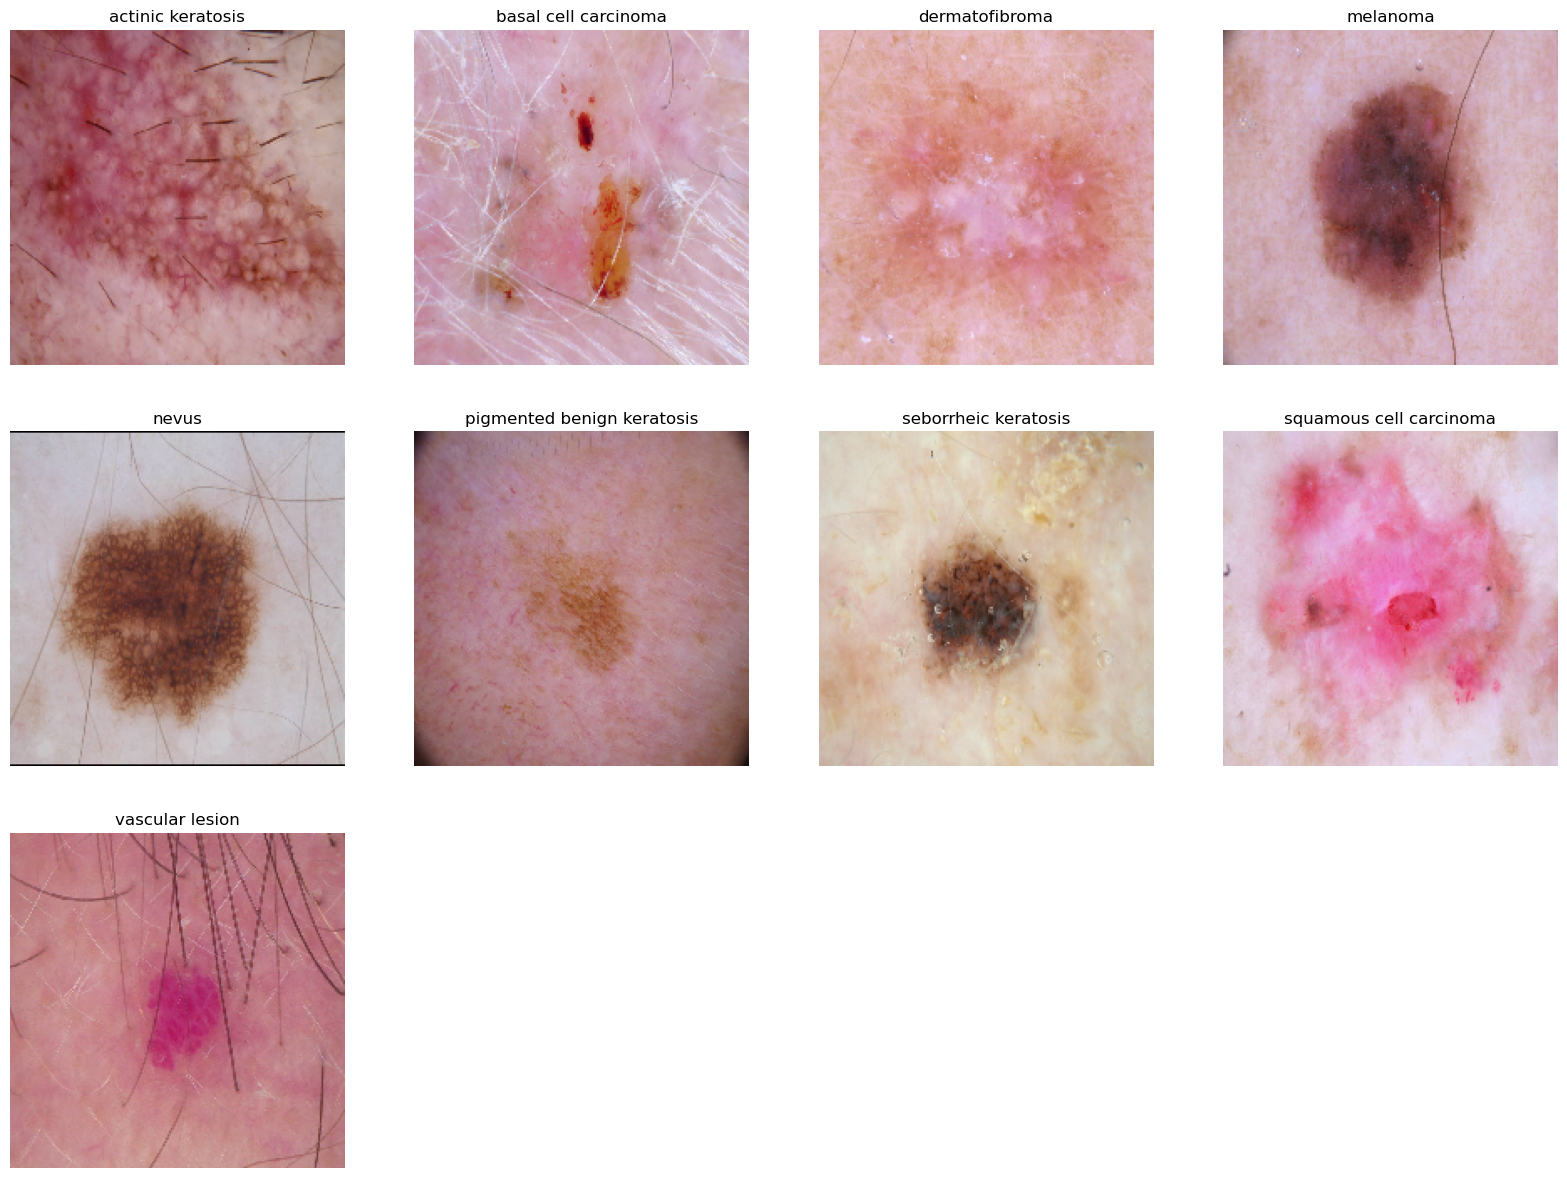

In [21]:
plt.figure(figsize=(20,20))
i = 0
for clas in class_names:
    path=str(data_dir_train)+'/'+clas+'/'+os.listdir(str(data_dir_train)+'/'+clas)[0]
    i += 1
    plt.subplot(4,4,i)
    plt.imshow(load_img(path,target_size=(200,200)))
    plt.title(clas)
    plt.axis("off")

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### We shall create a  CNN model, which can accurately detect 9 classes present in the dataset.We Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Let us use optimizer as **Adam** and loss function as **categorical_crossentropy** for building our model. 

#### Adam optimizer:
Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm

#### Categorical crossentropy:
Categorical cross-entropy is used for multi-class classification. Cross-entropy is different from KL divergence but can be calculated using KL divergence. It's also different from log loss but calculates the same quantity when used as a machine learning loss function.

In [24]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

### Train the model

Let us choose epochs as 20.

#### epochs:
one complete pass of the training dataset through the algorithm

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 67s 1s/step - loss: 1.9523 - accuracy: 0.2891 - val_loss: 1.8203 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 57s 1s/step - loss: 1.7451 - accuracy: 0.3588 - val_loss: 1.6335 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 54s 968ms/step - loss: 1.6025 - accuracy: 0.4342 - val_loss: 1.5041 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 52s 928ms/step - loss: 1.4691 - accuracy: 0.4872 - val_loss: 1.4679 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 50s 895ms/step - loss: 1.4298 - accuracy: 0.4972 - val_loss: 1.4824 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 50s 895ms/step - loss: 1.4063 - accuracy: 0.4799 - val_loss: 1.4411 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 51s 915ms/step - loss: 1.2803 - accuracy: 0.5419 - val_loss: 1.4242 - val_accuracy: 0.5101
Epoch

### Visualizing training results

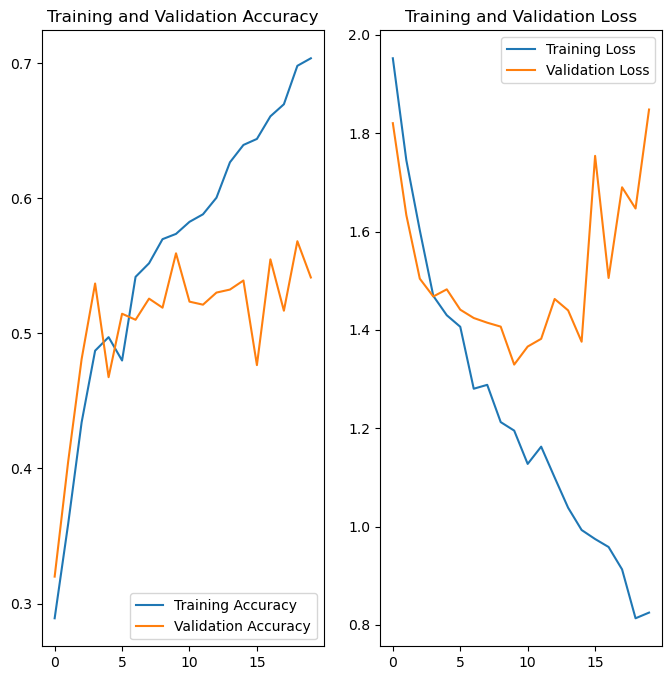

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

From the above graphs we can clearly see the model is working good for training and not for validation dataset and hence **it is overfitting**.
To overcome this we shall use some techniques like **data augmentation**.

#### Data augmentation:
Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data.It is used to reduce overfitting when training a machine learning model, by training models on several slightly-modified copies of existing data.

In [28]:
path_to_training_dataset="CNN_assignment/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to CNN_assignment/Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D2380E2910>: 100%|██████████████████| 500/500 [00:03<00:00, 132.14 Samples/s]


Initialised with 376 image(s) found.
Output directory set to CNN_assignment/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D238286700>: 100%|████████████████████████████████████| 500/500 [00:03<00:00, 137.36 Samples/s]


Initialised with 95 image(s) found.
Output directory set to CNN_assignment/Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1D22BE86280>: 100%|██████████████████| 500/500 [00:03<00:00, 138.44 Samples/s]


Initialised with 438 image(s) found.
Output directory set to CNN_assignment/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x1D23829C310>: 100%|█████████████████| 500/500 [00:22<00:00, 22.59 Samples/s]


Initialised with 357 image(s) found.
Output directory set to CNN_assignment/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x1D22BE87280>: 100%|█████████████████████████████████████| 500/500 [00:24<00:00, 20.46 Samples/s]


Initialised with 462 image(s) found.
Output directory set to CNN_assignment/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D22BE553D0>: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 82.25 Samples/s]


Initialised with 77 image(s) found.
Output directory set to CNN_assignment/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1D21920E0D0>: 100%|████████████████████████████████████| 500/500 [00:13<00:00, 37.47 Samples/s]


Initialised with 181 image(s) found.
Output directory set to CNN_assignment/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D21909F3D0>: 100%|█████████████████████████████████████| 500/500 [00:06<00:00, 81.92 Samples/s]


Initialised with 139 image(s) found.
Output directory set to CNN_assignment/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1D224ADB3D0>: 100%|█████████████████████████████████████| 500/500 [00:05<00:00, 87.15 Samples/s]


(-0.5, 199.5, 199.5, -0.5)

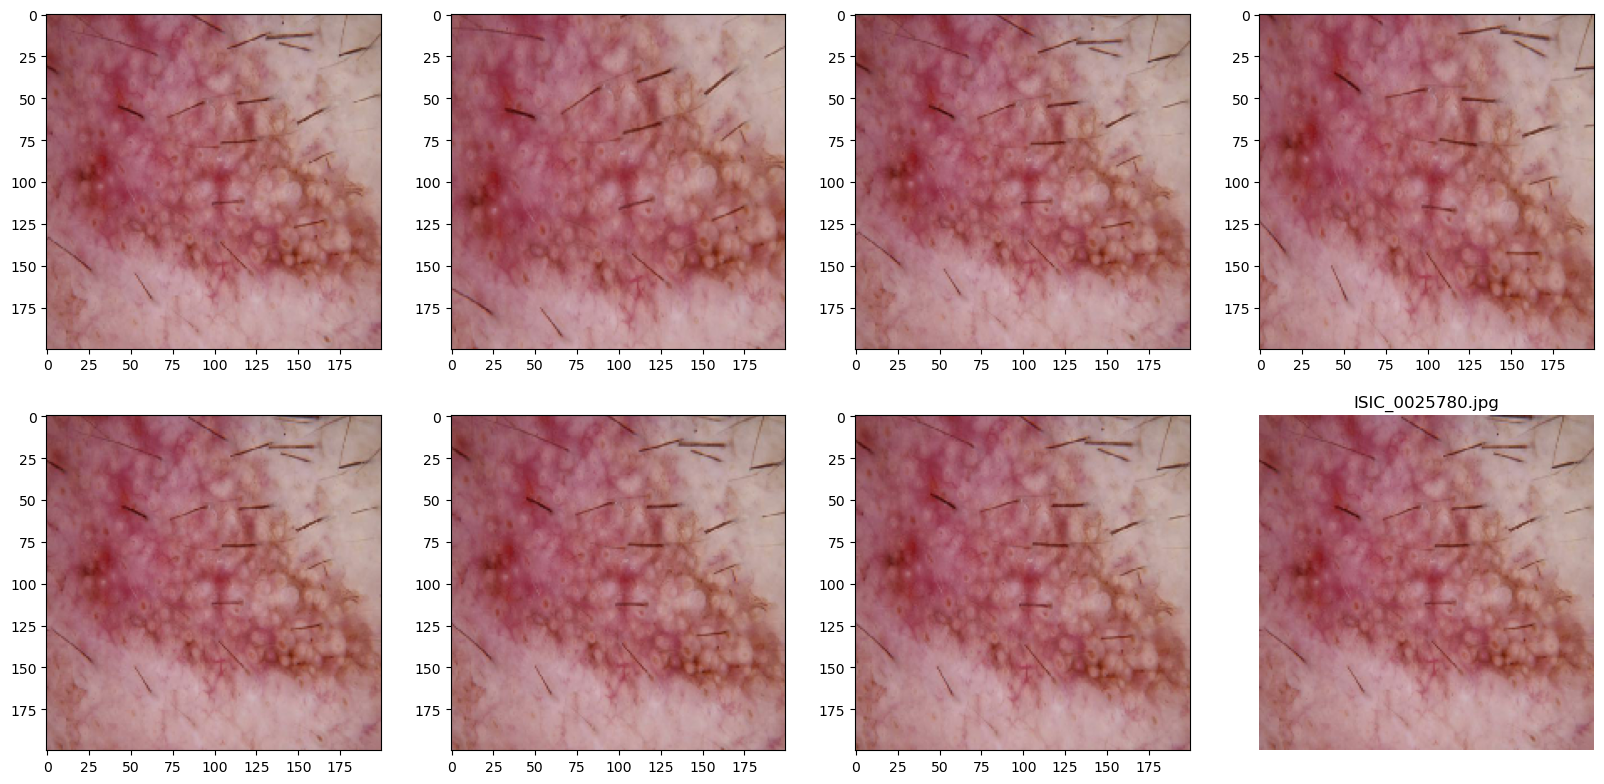

In [29]:
#Let us display copies of a single class image after augmentation
plt.figure(figsize=(20,20))
class_sample=os.listdir(str(data_dir_train)+'/'+class_names[0])[0]
path=str(data_dir_train)+'/'+class_names[0]+"/output"
i=1
for file in os.listdir(path):
    if class_sample in file:
        plt.subplot(4,4,i)
        i=i+1
        plt.imshow(load_img(os.path.join(path,file),target_size=(200,200)))
plt.title(class_sample)
plt.axis("off")

In [30]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Creating the model, compile and train the model


In [31]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

### Compiling the model

In [34]:
## Your code goes here
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

### Training the model

In [35]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
169/169 [==============================] - ETA: 0s - loss: 1.9356 - accuracy: 0.2659
Epoch 1: val_accuracy improved from -inf to 0.40535, saving model to model.h5


C:\Users\sbondugula\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - 178s 989ms/step - loss: 1.9356 - accuracy: 0.2659 - val_loss: 1.6298 - val_accuracy: 0.4053
Epoch 2/20
169/169 [==============================] - ETA: 0s - loss: 1.5125 - accuracy: 0.4201
Epoch 2: val_accuracy improved from 0.40535 to 0.50483, saving model to model.h5
169/169 [==============================] - 157s 931ms/step - loss: 1.5125 - accuracy: 0.4201 - val_loss: 1.3125 - val_accuracy: 0.5048
Epoch 3/20
169/169 [==============================] - ETA: 0s - loss: 1.3383 - accuracy: 0.4922
Epoch 3: val_accuracy improved from 0.50483 to 0.51373, saving model to model.h5
169/169 [==============================] - 156s 921ms/step - loss: 1.3383 - accuracy: 0.4922 - val_loss: 1.3142 - val_accuracy: 0.5137
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: 1.2331 - accuracy: 0.5349
Epoch 4: val_accuracy improved from 0.51373 to 0.59465, saving model to model.h5
169/169 [==============================] - 154s 914ms/step - los

### Visualizing the results

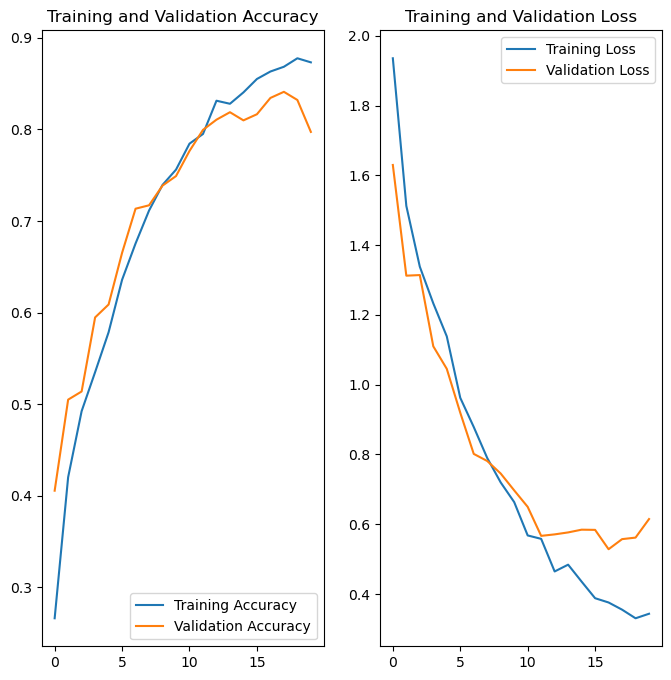

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 34ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


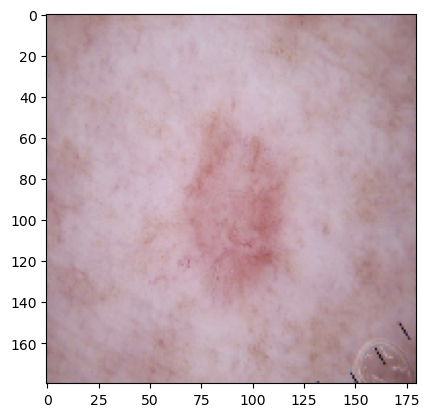

In [40]:
Test_image_path = os.path.join(data_dir_test, class_names[2], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )